#   MASTER
## Welcome to mat2py tool. This applies SH to process GRACE SH coefficients into Terrestrial water storage changes
#### Kindly provide the paths to respective files and outputs
#### 1. Reading SH coeffs from NASA JPL and replacing degree 1,2,3 coeffs'

In [1]:
path_sh = r"/home/wslvivek/Desktop/level2/pysh_v2/JPL_input/"                      # Path to JPL GRACE data
path_tn14 = r"/home/wslvivek/Desktop/level2/pysh_v2/JPL_TN_files/TN-14_C30_C20_GSFC_SLR.txt"    # Path to TN14
path_tn13 = r"/home/wslvivek/Desktop/level2/pysh_v2/JPL_TN_files/TN-13_GEOC_JPL_RL06.txt"       # Path to TN13

In [ ]:
path_sh = r"/home/wslvivek/Desktop/level2/pysh_v2/CSR_input/"    
path_tn14 = r"/home/wslvivek/Desktop/level2/pysh_v2/CSR_TN_files/TN-14_C30_C20_SLR_GSFC.txt"
path_tn13 = r"/home/wslvivek/Desktop/level2/pysh_v2/CSR_TN_files/TN-13_GEOC_CSR_RL06.1.txt" 

In [2]:
source=str(input("Enter the source of L2 SH coeffs code(jpl, csr, gfz): "))

Enter the source of L2 SH coeffs code(jpl, csr, gfz): jpl


In [3]:
import os
path_master = os.getcwd()                                            # current directory
path_functions = os.path.join(path_master,"pysh_funcs")        # directory of the sh bundle functions
path_output = os.path.join(os.path.dirname(path_master),"output")    # directory for output

In [4]:
from reader_replacer_jpl import reader_replacer_jpl
from reader_replacer_csr import reader_replacer_csr
from klm2sc import klm2sc
from clm2sc import clm2sc
from scrpit import tws_cal
from basin_avg import basin_avg
import numpy as np
import pandas as pd
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

In [5]:
%%time
if source == 'jpl':
    sh_clm, dates_start, dates_end, no_of_files = reader_replacer_jpl(path_sh, path_tn14, path_tn13)
elif source == 'csr':
    sh_clm, dates_start, dates_end, no_of_files = reader_replacer_csr(path_sh, path_tn14, path_tn13)
elif source== 'gfz':
    pass

JPL
Reading into clm format complete!
Number of files read: 201
Starting replacement
found: 37
Degree 2,3 replacement complete!
found: 116
Degree 1 replacement complete!
Number of months of data in each year starting 2002-04-04 & ending 2022-07-01 [ 7. 11.  8. 12. 12. 12. 12. 12. 12. 10.  7.  9.  9.  7.  9.  5.  5. 12.
 12. 12.  6.  0.]
CPU times: user 3.45 s, sys: 66.8 ms, total: 3.52 s
Wall time: 3.51 s


* `sh_clm` is a ndarray containg lists of data: degree;  order; clm; slm; delta clm; delta slm; start data; end date*

#### 2. The following cells perform a bunch of operations


* Storing SH coeffs in clm format into SC format
* Calculation of delta clm & delta slm
* Application of Gaussian filter/filter of user choice
* Application of filter to delta clm, slm to get filtered SH coeffs
* Calling gshs() with filtered SH coeffs to obtain TWS fields
* Flipping the TWS fields to get 0 degree longitude in the middle
* Saving data in netCDF4 format and writing to disk

In [6]:
if source == 'jpl':
    sc_mat_raw = clm2sc(sh_clm);
elif source == 'csr':
    sc_mat_raw = klm2sc(sh_clm);
elif source== 'gfz':
    pass
print('conversion to sc format complete!\n')

conversion to sc format complete!



In [7]:
lmax = 96
gs = 1
half_rad_gf = 500

In [ ]:
print('Kindly enter the following parameters based on your application')
lmax = int(input("Enter lmax: "))
gs = int(input("Enter grid size: "))
half_rad_gf = int(input("Enter half radius of Gaussian filter: "))
print("lmax , grid size & half raduius of gaussian filter are : ", lmax ,", " , gs,", ",half_rad_gf)

In [8]:
lon = np.arange(-180,180,gs)
lat = np.arange(89,-91,-gs)
# dates = pd.to_datetime(pd.Series(dates_start), format='%Y-%m-%d').dt.strftime('%d-%m-%Y') \
#         + "    " \
#         +pd.to_datetime(pd.Series(dates_end), format='%Y-%m-%d').dt.strftime('%d-%m-%Y')
dates = pd.to_datetime(pd.Series(dates_start), format='%Y-%m-%d')#.dt.strftime('%d-%m-%Y')
print('dates read! \n')

dates read! 



In [9]:
dates.to_csv(path_output+'/dates.txt')

##### Remove long term mean to get anomalies
* Long term mean is calculated from NASA JPL SH coeffs in the period 01-01-2005 & 31-12-2010 (6 years continuous)

In [10]:
SH_long_mean_jpl = np.load(path_master+'/long_mean/SH_long_mean_jpl.npy')    # load the long term mean SH coeffs---> JPL 
SH_long_mean_csr = np.load(path_master+'/long_mean/SH_long_mean_csr.npy')    # load the long term mean SH coeffs---> CSR
if source== 'jpl':
    sc_mat = sc_mat_raw - SH_long_mean_jpl
elif source== 'csr':
    sc_mat = sc_mat_raw - SH_long_mean_csr
elif source== 'gfz':
    pass

CPU times: user 12.8 s, sys: 59.5 ms, total: 12.9 s
Wall time: 12.8 s


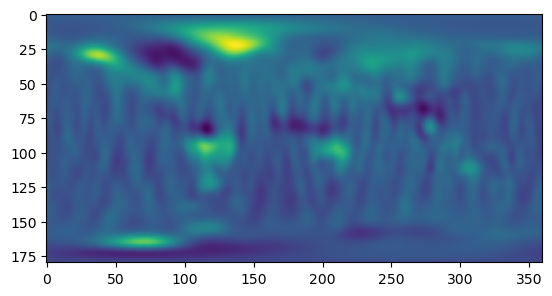

In [11]:
%%time
tws_fields = tws_cal(sc_mat,lmax,gs,half_rad_gf,no_of_files,path_functions)
tws_fields = np.float32(tws_fields)

In [12]:
ds = xr.Dataset(
    data_vars=dict(
        tws=(["time","lat", "lon"], tws_fields)
    ),
    coords = {
        "time":(('time'),dates),
        "lat":lat,
        "lon":lon },
    attrs=dict(description="TWS Anomaly corresponding to long term (2004-2010) mean \n lmax=96 and half radius of Gaussian filter = 500Km"),
)
ds

<xarray.Dataset>
Dimensions:  (time: 201, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 2002-04-04 2002-05-02 ... 2022-06-01
  * lat      (lat) int64 89 88 87 86 85 84 83 82 ... -84 -85 -86 -87 -88 -89 -90
  * lon      (lon) int64 -180 -179 -178 -177 -176 -175 ... 175 176 177 178 179
Data variables:
    tws      (time, lat, lon) float32 -2.598 -2.549 -2.499 ... 124.2 124.4 124.6
Attributes:
    description:  TWS Anomaly corresponding to long term (2004-2010) mean \n ...

In [ ]:
ds.tws.isel(time=170).plot()

In [ ]:
ds.to_netcdf(path_output+'/'+source+'_tws.nc', engine="netcdf4")

## Basin average

Do you want to calculate basin average?(y/n):y
Enter projected reference system:32645
Area of basin in km2: 768353.6291053339


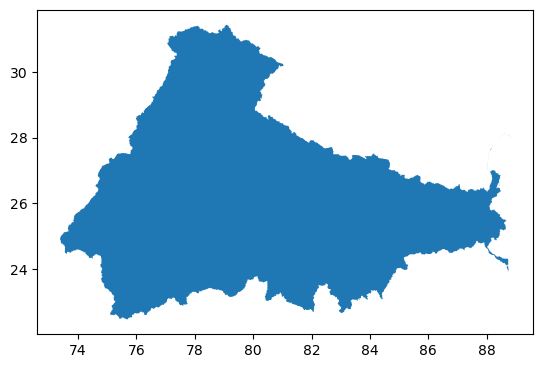

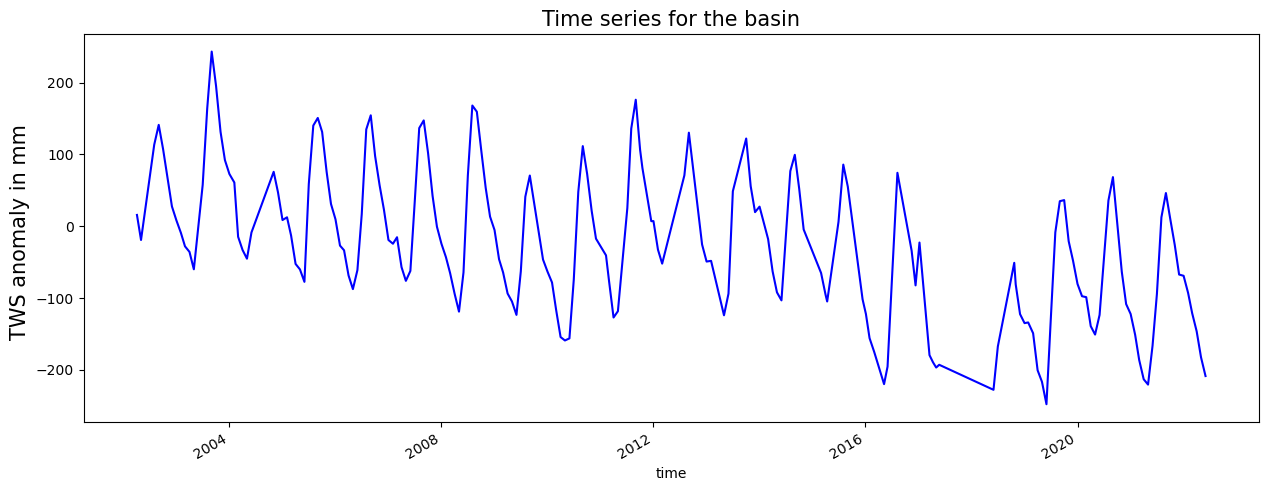

In [13]:
ans = str(input('Do you want to calculate basin average?(y/n):'))
if ans == 'y':
    path_shapefile = r"/home/wslvivek/Desktop/garca/vivek/Ganga.shp"
    c_rs = str(input('Enter projected reference system:'))
    tws_basin_avg = basin_avg(ds,path_shapefile,c_rs,no_of_files,gs)
else:
    pass

In [ ]:
tws_basin_avg.to_netcdf(path_output+'/tws_basin_avg.nc', engine="netcdf4")